## Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [2]:
import os
import gc
import sys
import time
import json
import glob
import random
from pathlib import Path
import pandas as pd

from PIL import Image
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from collections import ChainMap

import itertools
from tqdm import tqdm

## Settings

In [3]:
input_dir = '/content/drive/MyDrive/Colab Notebooks Private/center_pivot_irrigation_instance_segmentation'
output_dir = input_dir
category_list = ["pivot"]
NUM_CATS = len(category_list)
IMAGE_SIZE = 512

In [4]:
train_df = pd.read_csv(input_dir + '/train.csv')
train_df = train_df.dropna()
train_df.head()

Image_Label                                      EncodedPixels
0  LANDSAT-id-0-1024-0.jpg_pivot  1859 6 2368 13 2878 17 3389 19 3900 21 4411 23...
1  LANDSAT-id-0-1024-0.jpg_pivot  14112 4 14620 12 15130 16 15640 20 16151 22 16...
2  LANDSAT-id-0-1024-0.jpg_pivot  131247 3 131755 11 132265 15 132776 18 133287 ...
3  LANDSAT-id-0-1024-0.jpg_pivot  80607 7 81116 12 81627 15 82137 18 82649 19 83...
4  LANDSAT-id-0-1024-0.jpg_pivot  4958 4 5467 10 5978 12 6489 15 7000 16 7511 18...

In [5]:
train_dict = {}
train_class_dict = {}
for idx, row in train_df.iterrows():
    image_filename, class_name = row.Image_Label.split("_")
    
    class_id = category_list.index(class_name)
    if train_dict.get(image_filename):
        train_dict[image_filename].append(row.EncodedPixels)
        train_class_dict[image_filename].append(class_id)
    else:
        train_dict[image_filename] = [row.EncodedPixels]
        train_class_dict[image_filename] = [class_id]

In [6]:
df = pd.DataFrame(columns=["image_id","EncodedPixels","CategoryId","Width","Height"])
for key, value in train_dict.items():
    df = df.append({"image_id": key, "EncodedPixels": value, "CategoryId": train_class_dict[key], "Width": IMAGE_SIZE, "Height": IMAGE_SIZE},ignore_index=True)

df.head()

image_id  ... Height
0    LANDSAT-id-0-1024-0.jpg  ...    512
1    LANDSAT-id-0-1536-0.jpg  ...    512
2  LANDSAT-id-0-1536-512.jpg  ...    512
3  LANDSAT-id-0-3072-512.jpg  ...    512
4    LANDSAT-id-0-0-1024.jpg  ...    512

[5 rows x 5 columns]

In [7]:
!git clone https://www.github.com/saraivaufc/Mask_RCNN.git
os.chdir('Mask_RCNN')

!rm -rf .git
!rm -rf images assets

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 983 (delta 0), reused 0 (delta 0), pack-reused 979
Receiving objects: 100% (983/983), 125.29 MiB | 36.68 MiB/s, done.
Resolving deltas: 100% (574/574), done.


In [8]:
sys.path.append('../Mask_RCNN')
from mrcnn.config import Config

from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [9]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'

-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


In [10]:
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

('/content/drive/MyDrive/Colab Notebooks Private/center_pivot_irrigation_instance_segmentation/train_images/LANDSAT-id-152-2048-1536.jpg', ['pivot', 'pivot'])


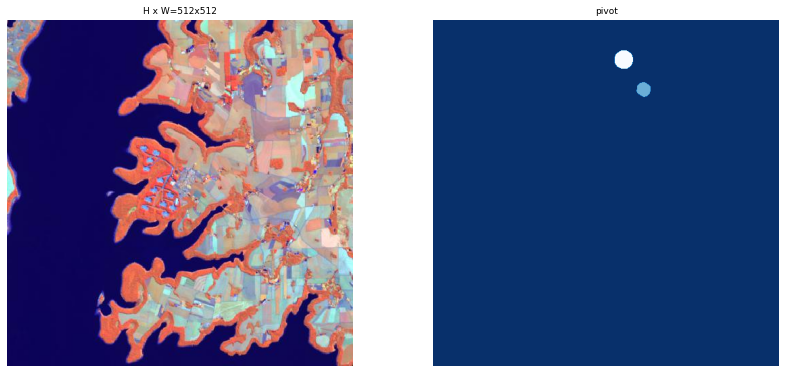

('/content/drive/MyDrive/Colab Notebooks Private/center_pivot_irrigation_instance_segmentation/train_images/LANDSAT-id-118-512-3072.jpg', ['pivot'])


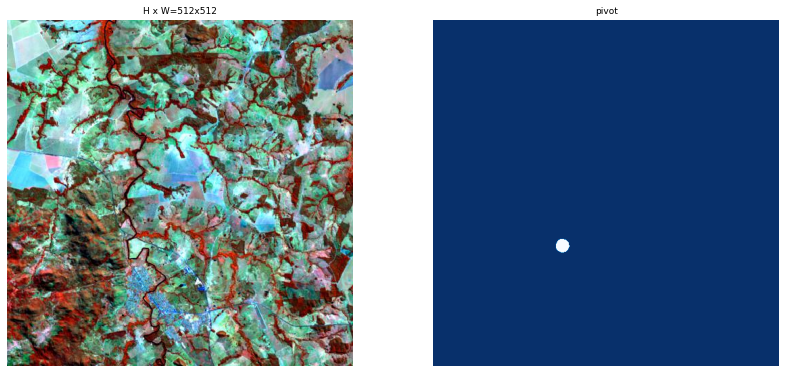

('/content/drive/MyDrive/Colab Notebooks Private/center_pivot_irrigation_instance_segmentation/train_images/LANDSAT-id-187-512-3072.jpg', ['pivot', 'pivot', 'pivot', 'pivot', 'pivot'])


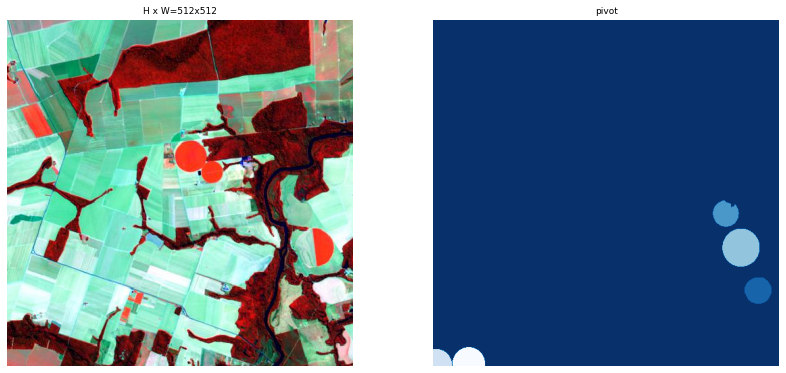

In [11]:
class Dataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        # Add classes
        for i, name in enumerate(category_list):
            self.add_class("dataset", i+1, name)
        
        # Add images 
        for i, row in df.iterrows():
            self.add_image("dataset", 
                           image_id=row.name, 
                           path=input_dir + '/train_images/'+str(row.image_id), 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [category_list[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                try:
                    sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1
                except Exception:
                    pass

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            sub_mask = np.rot90(sub_mask, 1)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)
training_percentage = 0.9

training_set_size = int(training_percentage*len(df))
validation_set_size = int((1-training_percentage)*len(df))

train_dataset = Dataset(df[:training_set_size])
train_dataset.prepare()

valid_dataset = Dataset(df[training_set_size:training_set_size+validation_set_size])
valid_dataset.prepare()

for i in range(3):
    image_id = random.choice(train_dataset.image_ids)
    print(train_dataset.image_reference(image_id))
    
    image = train_dataset.load_image(image_id)
    mask, class_ids = train_dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, train_dataset.class_names, limit=NUM_CATS)

In [12]:
LR = 1e-4
EPOCHS = [5,10]

import warnings 
warnings.filterwarnings("ignore")

In [13]:
class DatasetConfig(Config):
    NAME = "dataset"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4 #That is the maximum with the memory available on kernels
    
    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'

    STEPS_PER_EPOCH = 1000
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    
config = DatasetConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [14]:
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5)
], random_order=True)

In [15]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=output_dir)

model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    'mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

In [16]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR*2,
            epochs=EPOCHS[0],
            layers='heads',
            augmentation=None)

history = model.keras_model.history.history


Starting at epoch 0. LR=0.0002

Checkpoint Path: /content/drive/MyDrive/Colab Notebooks Private/center_pivot_irrigation_instance_segmentation/dataset20201230T1303/mask_rcnn_dataset_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistri

In [17]:
%%time
model.train(train_dataset, valid_dataset,
            learning_rate=LR,
            epochs=EPOCHS[1],
            layers='all',
            augmentation=augmentation)
new_history = model.keras_model.history.history


Starting at epoch 5. LR=0.0001

Checkpoint Path: /content/drive/MyDrive/Colab Notebooks Private/center_pivot_irrigation_instance_segmentation/dataset20201230T1303/mask_rcnn_dataset_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_bra

In [18]:
for k in new_history: history[k] = history[k] + new_history[k]

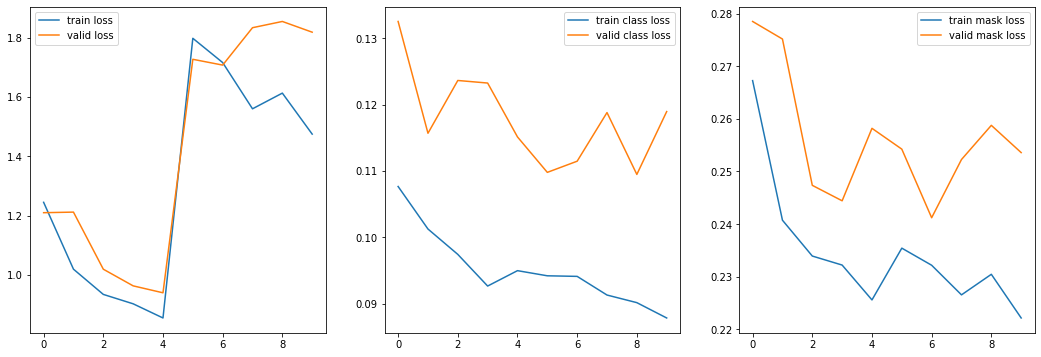

In [19]:
epochs = range(EPOCHS[-1])

plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history['mrcnn_class_loss'], label="train class loss")
plt.plot(epochs, history['val_mrcnn_class_loss'], label="valid class loss")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history['mrcnn_mask_loss'], label="train mask loss")
plt.plot(epochs, history['val_mrcnn_mask_loss'], label="valid mask loss")
plt.legend()

plt.show()

In [20]:
best_epoch = np.argmin(history["val_loss"]) + 1
print("Best epoch: ", best_epoch)
print("Valid loss: ", history["val_loss"][best_epoch-1])

Best epoch:  5
Valid loss:  0.9398165380954743


In [21]:
class InferenceConfig(DatasetConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=output_dir)

Instructions for updating:
Use fn_output_signature instead


In [22]:
glob_list = glob.glob(f'{output_dir}/dataset*/mask_rcnn_dataset_{best_epoch:04d}.h5')
model_path = glob_list[0] if glob_list else ''
model.load_weights(model_path, by_name=True)

Re-starting from epoch 5


In [23]:
# Fix overlapping masks
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

In [24]:
sample_df = pd.read_csv(f'{input_dir}/test.csv')

In [25]:
sample_df.head()

Image_Label                                      EncodedPixels
0  LANDSAT-1024-0.jpg_CenterPivot  1300 4 1809 12 2319 17 2829 21 3339 24 3849 28...
1  LANDSAT-1024-0.jpg_CenterPivot  10478 5 10987 12 11497 17 12007 21 12517 24 13...
2  LANDSAT-1024-0.jpg_CenterPivot  22800 7 23308 16 23818 20 24328 24 24838 27 25...
3  LANDSAT-1024-0.jpg_CenterPivot  215704 6 216212 14 216722 18 217232 22 217743 ...
4  LANDSAT-1024-0.jpg_CenterPivot  216176 6 216684 14 217194 18 217705 21 218215 ...

In [26]:
test_df = pd.DataFrame(columns=["image_id","EncodedPixels","CategoryId"])
for idx,row in sample_df.iterrows():
    image_filename = row.Image_Label.split("_")[0]
    test_df = test_df.append({"image_id": image_filename},ignore_index=True)
test_df = test_df.drop_duplicates()
test_df.head()

image_id EncodedPixels CategoryId
0     LANDSAT-1024-0.jpg           NaN        NaN
9    LANDSAT-512-512.jpg           NaN        NaN
41  LANDSAT-1024-512.jpg           NaN        NaN
73    LANDSAT-0-1024.jpg           NaN        NaN
85  LANDSAT-512-1024.jpg           NaN        NaN

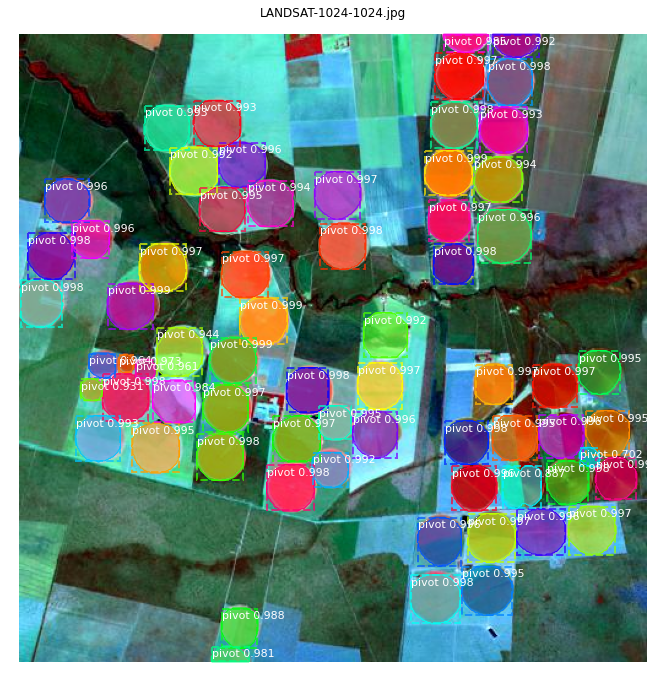

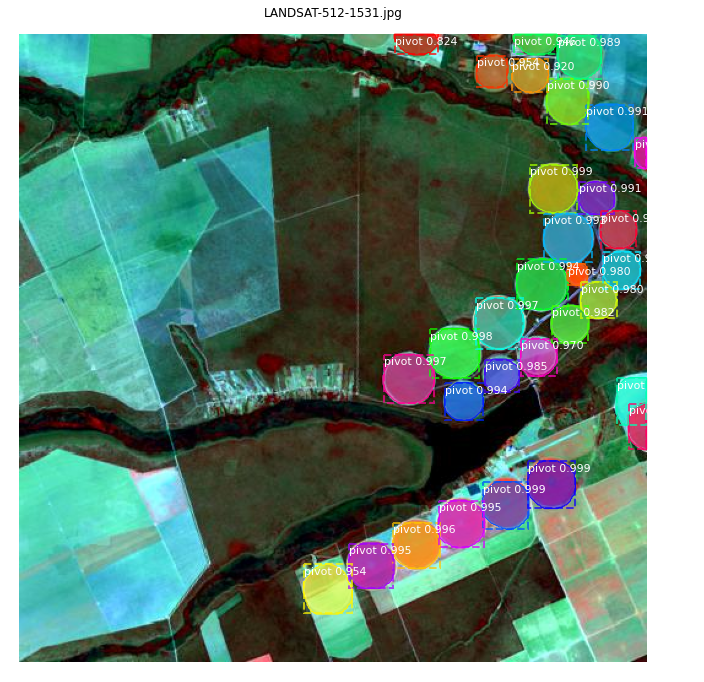

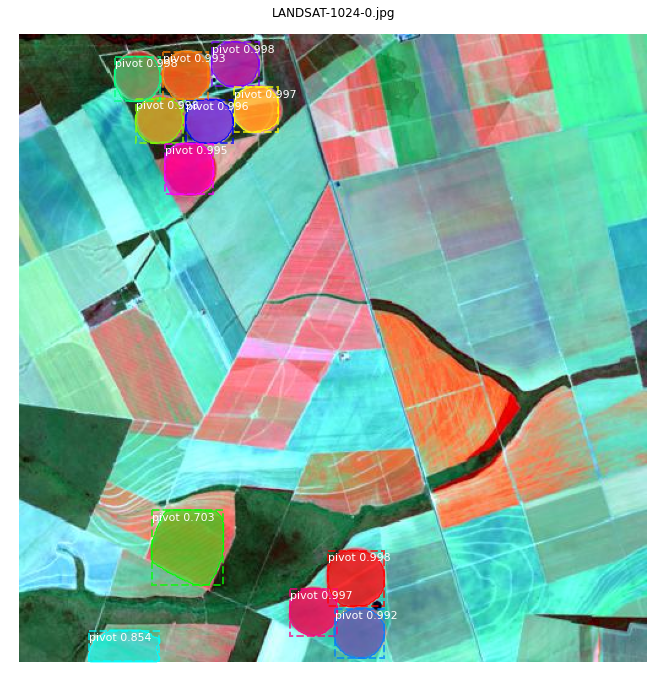

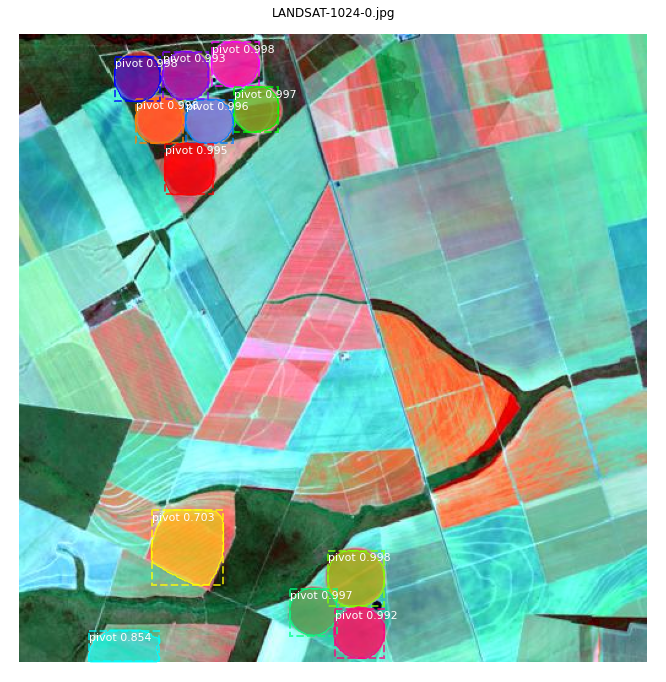

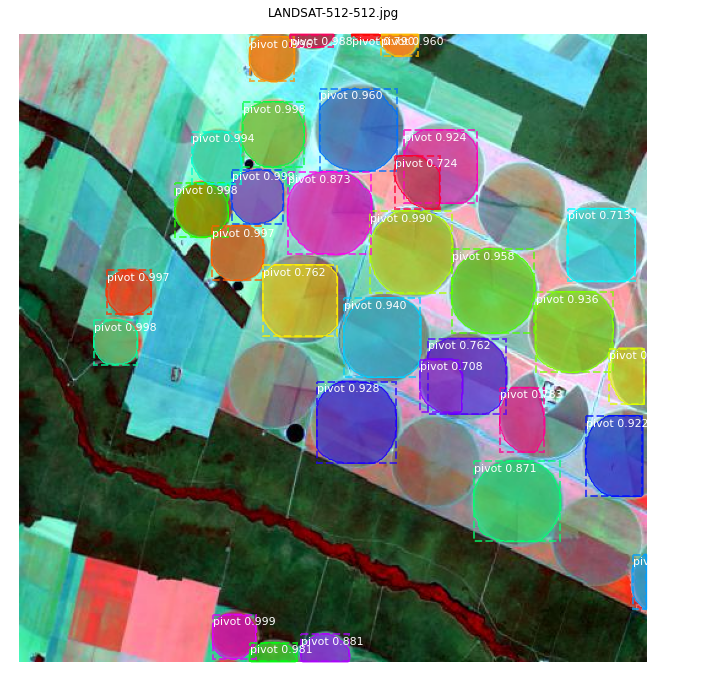

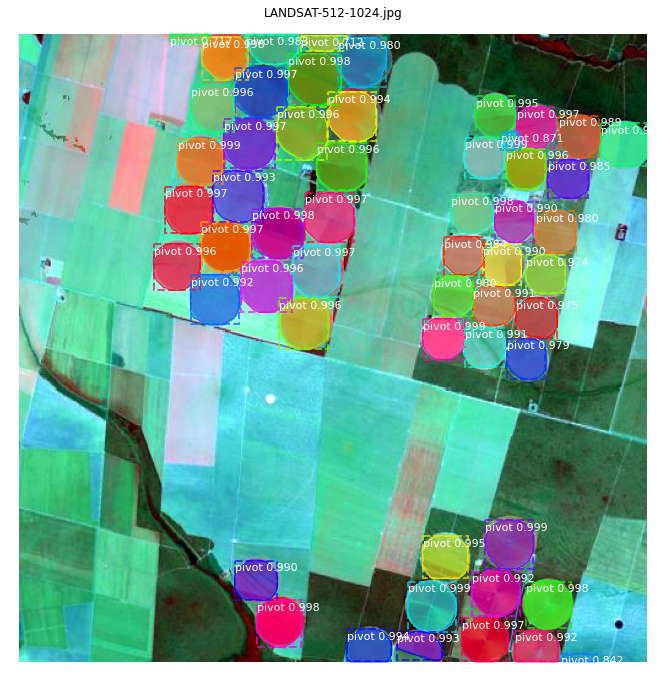

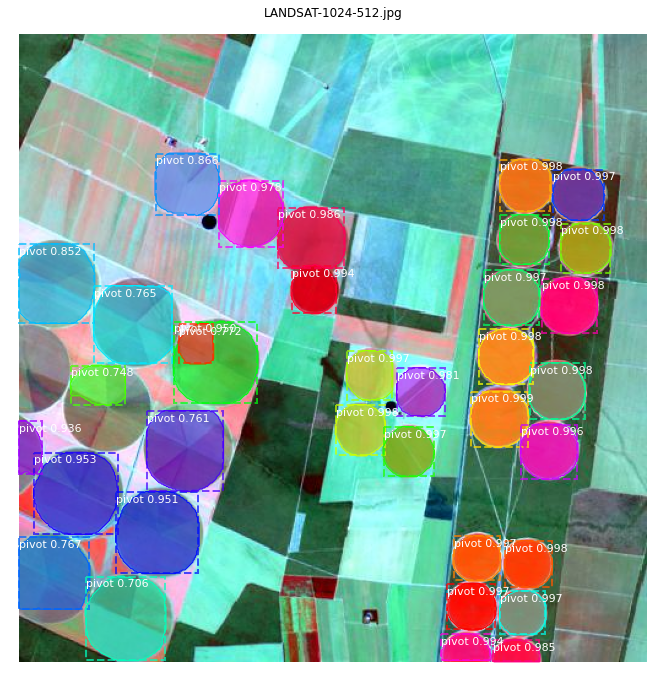

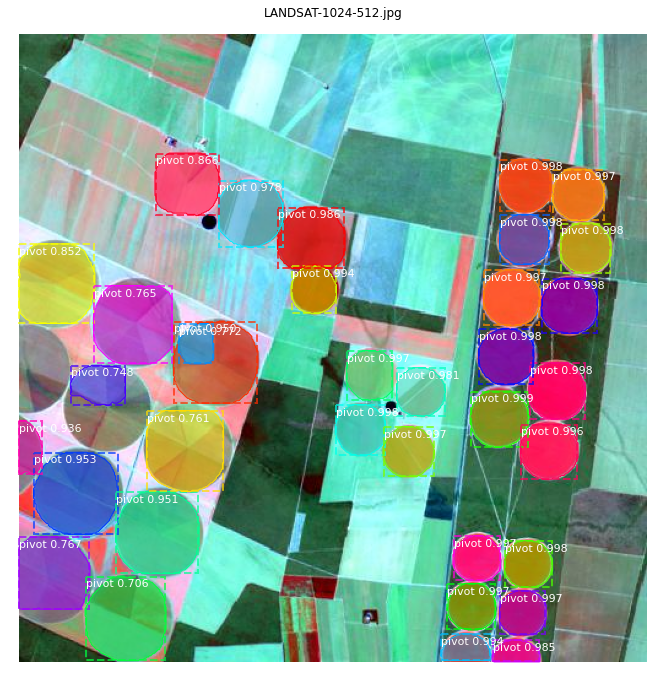

In [27]:
for i in range(8):
    image_id = test_df.sample()["image_id"].values[0]
    image_path = str(f'{input_dir}/test_images/'+image_id)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result = model.detect([resize_image(image_path)])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
        
    visualize.display_instances(img, rois, masks, r['class_ids'], 
                                ['bg']+category_list, r['scores'],
                                title=image_id, figsize=(12, 12))

In [28]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join([str(x) for x in run_lengths])

In [29]:
submission_df = sample_df.copy()
submission_df["EncodedPixels"] = ""
with tqdm(total=len(test_df)) as pbar:
    for i,row in test_df.iterrows():
        pbar.update(1)
        image_id = row["image_id"]
        image_path = str(f'{input_dir}/test_images/'+image_id)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        result = model.detect([resize_image(image_path)])
        r = result[0]

        if r['masks'].size > 0:
            masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
            for m in range(r['masks'].shape[-1]):
                masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                            (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

            y_scale = img.shape[0]/IMAGE_SIZE
            x_scale = img.shape[1]/IMAGE_SIZE
            rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
            masks, rois, class_ids = r['masks'], r['rois'], r['class_ids']

            #The following piece of code is creating rectangular masks from
            # the ROIs instead of using the masks drawn by the MaskRCNN.
            # It also removes any missing area from the imagery from the predicted masks.
            # Everything is added directly to the submission dataframe.
            rectangular_masks = []
            mask_dict = dict(ChainMap(*list(map(lambda x: {x: []}, category_list))))
            
            for roi, class_id in zip(rois, class_ids):
                rectangular_mask = np.zeros((512,512))
                rectangular_mask[roi[0]:roi[2], roi[1]:roi[3]] = 255
                img = cv2.resize(img, dsize=(512,512), interpolation = cv2.INTER_LINEAR)
                cropped_img = img[roi[0]:roi[2], roi[1]:roi[3]]
                
                kernel = np.ones((5,5),np.uint8)
                missing_data = np.where(cropped_img[:,:,0]==0,255,0).astype('uint8')
                contour_mask = np.zeros(missing_data.shape)
                opening = cv2.morphologyEx(missing_data.astype('uint8'), cv2.MORPH_OPEN, kernel)
                contours= cv2.findContours(opening,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
                if len(contours[0])>0:
                    largest_contour = max(contours[0], key = cv2.contourArea)
                    cv2.fillPoly(contour_mask, pts =[largest_contour], color=(255))
                    kernel = np.ones((5,5),np.uint8)
                    opening = cv2.morphologyEx(contour_mask, cv2.MORPH_OPEN, kernel)
                    fixed_mask = np.where(opening[:,:]==255,0,255)
                    rectangular_mask[roi[0]:roi[2], roi[1]:roi[3]] = fixed_mask.copy()
                    
                if mask_dict[category_list[class_id-1]]==[]:
                    mask_dict[category_list[class_id-1]] = rectangular_mask
                else:
                    previous_mask = mask_dict[category_list[class_id-1]].copy()
                    #prevents a bug where the mask is in int64
                    previous_mask = previous_mask.astype('float64')
                    boolean_mask = np.ma.mask_or(previous_mask, rectangular_mask)
                    merged_mask = np.where(boolean_mask, 255, 0)
                    mask_dict[category_list[class_id-1]] = merged_mask

            
            #Going through the masks per category and create a md mask in RLE
            for cloud_category in mask_dict.keys():
                if mask_dict[cloud_category]!=[]:
                    #resizing for submission
                    resized_mask = cv2.resize((mask_dict[cloud_category]/255).astype('uint8'), dsize=(525,350), interpolation = cv2.INTER_LINEAR)
                    rle_str = rle_encoding(resized_mask)
                    image_label = "{}_{}".format(image_id,cloud_category)
                    submission_df.loc[submission_df['Image_Label']==image_label,'EncodedPixels'] = rle_str
        else:
            masks, rois = r['masks'], r['rois']

100%|██████████| 11/11 [00:04<00:00,  2.38it/s]


In [30]:
submission_df.query("EncodedPixels!=''").head()

Empty DataFrame
Columns: [Image_Label, EncodedPixels]
Index: []

In [31]:
submission_df.to_csv(f'{output_dir}/submission.csv',index=False)